In [169]:
# Import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Introduction

This dataset was taken from Kaggle.com. It contains very rich information on loan data from years 2007-2015.
My goal here was to predict credit grade using classification models, and comment on how I would move forward.

My first steps in EDA were to examine the missing values present in the dataset, and do some initial relationship between credit grade and other features.

In [2]:
# Initial look at the data 
df = pd.read_csv('loan.csv', low_memory=False)
df.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,5550,5550,5550.0,36 months,15.02,192.45,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,2000,2000,2000.0,36 months,17.97,72.28,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,6000,6000,6000.0,36 months,13.56,203.79,C,C1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,6000,6000,6000.0,36 months,14.47,206.44,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


I took a look at the missing values distribution

Text(0.5,1,'Frequency of Real values per column')

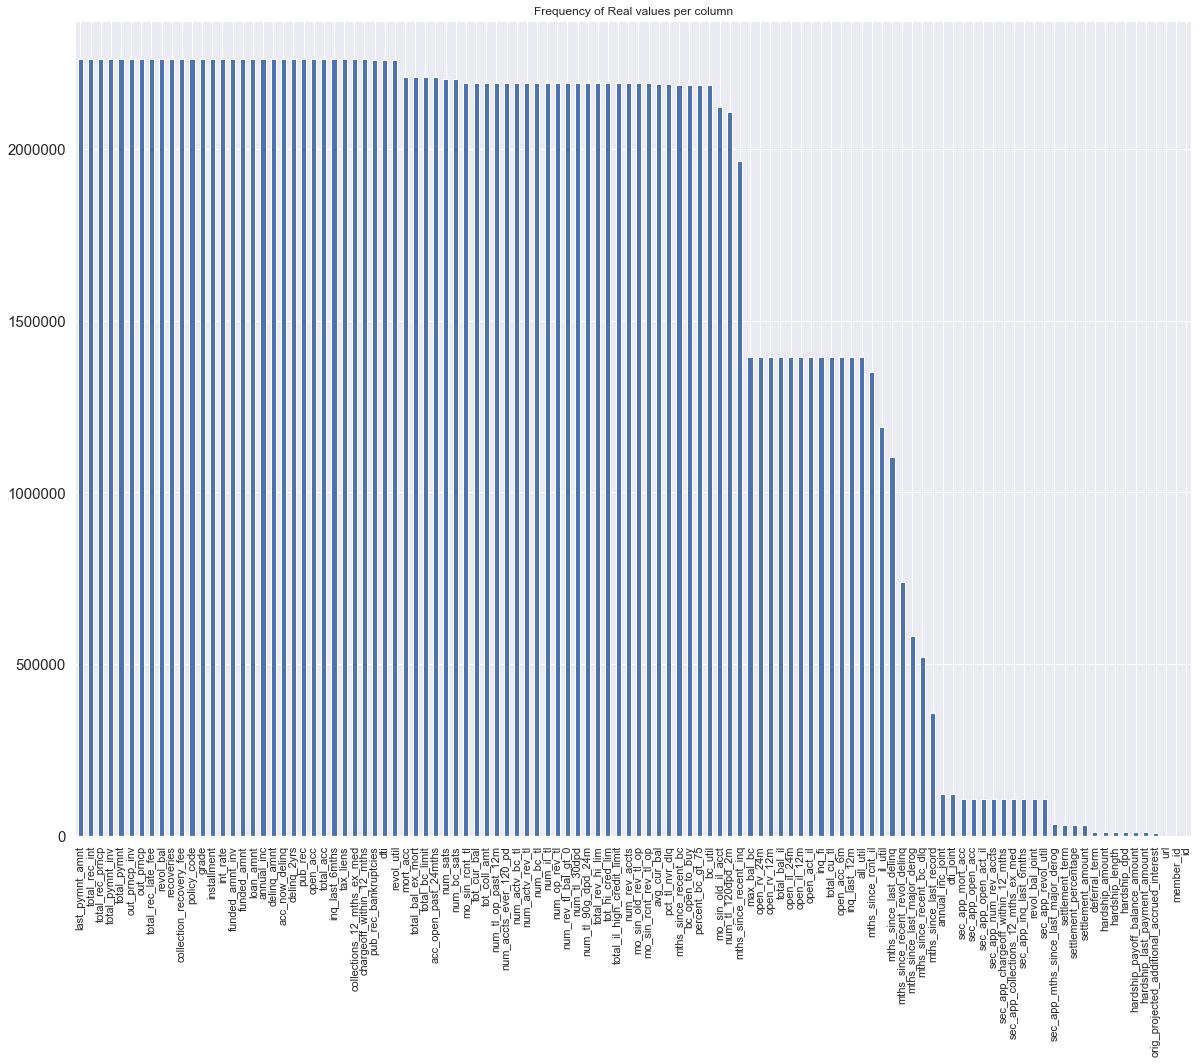

In [186]:
plt.figure(figsize=(20,15))
df.describe().loc['count'].sort_values(ascending = False).plot(kind = 'bar', color = 'b').tick_params(axis="y", labelsize=15);
plt.title('Frequency of Real values per column')


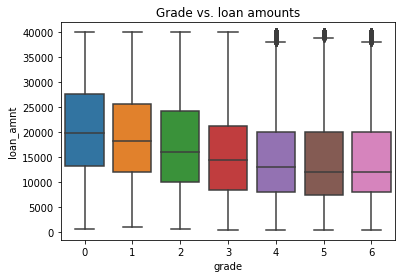

In [106]:
# Relationship between Grade and Loan Amount

sns.boxplot(x="grade", y="loan_amnt", data=df);
plt.title('Grade vs. Loan Amounts');

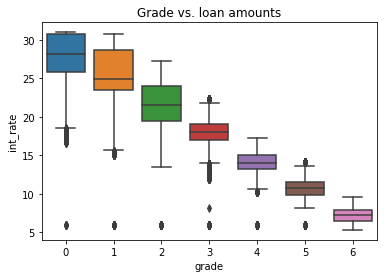

In [107]:
# Relationship betweenGrade and Interest rate

sns.boxplot(x="grade", y="int_rate", data=df);
plt.title('Grade vs. Interest Rates');

- People who ask for higher loans have lower credit grade
- People with higher interest rates have lower credit grades
- A very large portion of consumers have no inquires in lat 6 months


## Data Pre-Processing: Categorical Variables

Next I begin to fill in the missing values in the categorical variables.

In [3]:
# TO be able to extract all the categorical variables and numerical variables 

cat_var = [col for col in df.columns if df[col].dtype.name == 'object']
num_var = [col for col in df.columns if df[col].dtype.name == 'int64' or df[col].dtype.name == 'float64']

print(len(cat_var))
print(len(num_var))

36
109


There are 36 categorical variables and 109 numerical variables. Looking deeper into the categorical variables...

In [83]:
df['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [84]:
df[cat_var].head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
0,36 months,4,C1,Chef,10+ years,RENT,Not Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
1,60 months,3,D2,Postmaster,10+ years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
2,36 months,3,D1,Administrative,6 years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
3,36 months,3,D2,IT Supervisor,10+ years,MORTGAGE,Source Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN
4,60 months,4,C4,Mechanic,10+ years,MORTGAGE,Not Verified,Dec-2018,Current,n,...,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN


In [85]:
# Extra glance at the remainder variables

df[['desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint',
 'sec_app_earliest_cr_line',
 'hardship_flag',
 'hardship_type',
 'hardship_reason']].head()

,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,sec_app_earliest_cr_line,hardship_flag,hardship_type,hardship_reason
0,NaN,debt_consolidation,Debt consolidation,109xx,NY,Apr-2001,w,Feb-2019,Mar-2019,Feb-2019,Individual,NaN,NaN,N,NaN,NaN
1,NaN,debt_consolidation,Debt consolidation,713xx,LA,Jun-1987,w,Feb-2019,Mar-2019,Feb-2019,Individual,NaN,NaN,N,NaN,NaN
2,NaN,debt_consolidation,Debt consolidation,490xx,MI,Apr-2011,w,Feb-2019,Mar-2019,Feb-2019,Individual,NaN,NaN,N,NaN,NaN
3,NaN,debt_consolidation,Debt consolidation,985xx,WA,Feb-2006,w,Feb-2019,Mar-2019,Feb-2019,Individual,NaN,NaN,N,NaN,NaN
4,NaN,debt_consolidation,Debt consolidation,212xx,MD,Dec-2000,w,Feb-2019,Mar-2019,Feb-2019,Individual,NaN,NaN,N,NaN,NaN


## Very important to note below

**grade** is an Ordinal variable, 'A' being the highest and 'G' being the lowest, thus I replace the Letter grades with variables accordingly.

In [5]:
num_grades = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
df['grade'] = df['grade'].replace(num_grades)
df.grade.head()

0    4
1    3
2    3
3    3
4    4
Name: grade, dtype: int64

## first_df Tech Lab

Moving forward, due to the size of the dataset and to improve computational speed, I took the sample of the dataset, **first_df** and continued my EDA and wrangling using it. The barplot below showed an identical distribution of real/missing values compared to the whole dataset, meaning it should be safe to continue on with **first_df**.

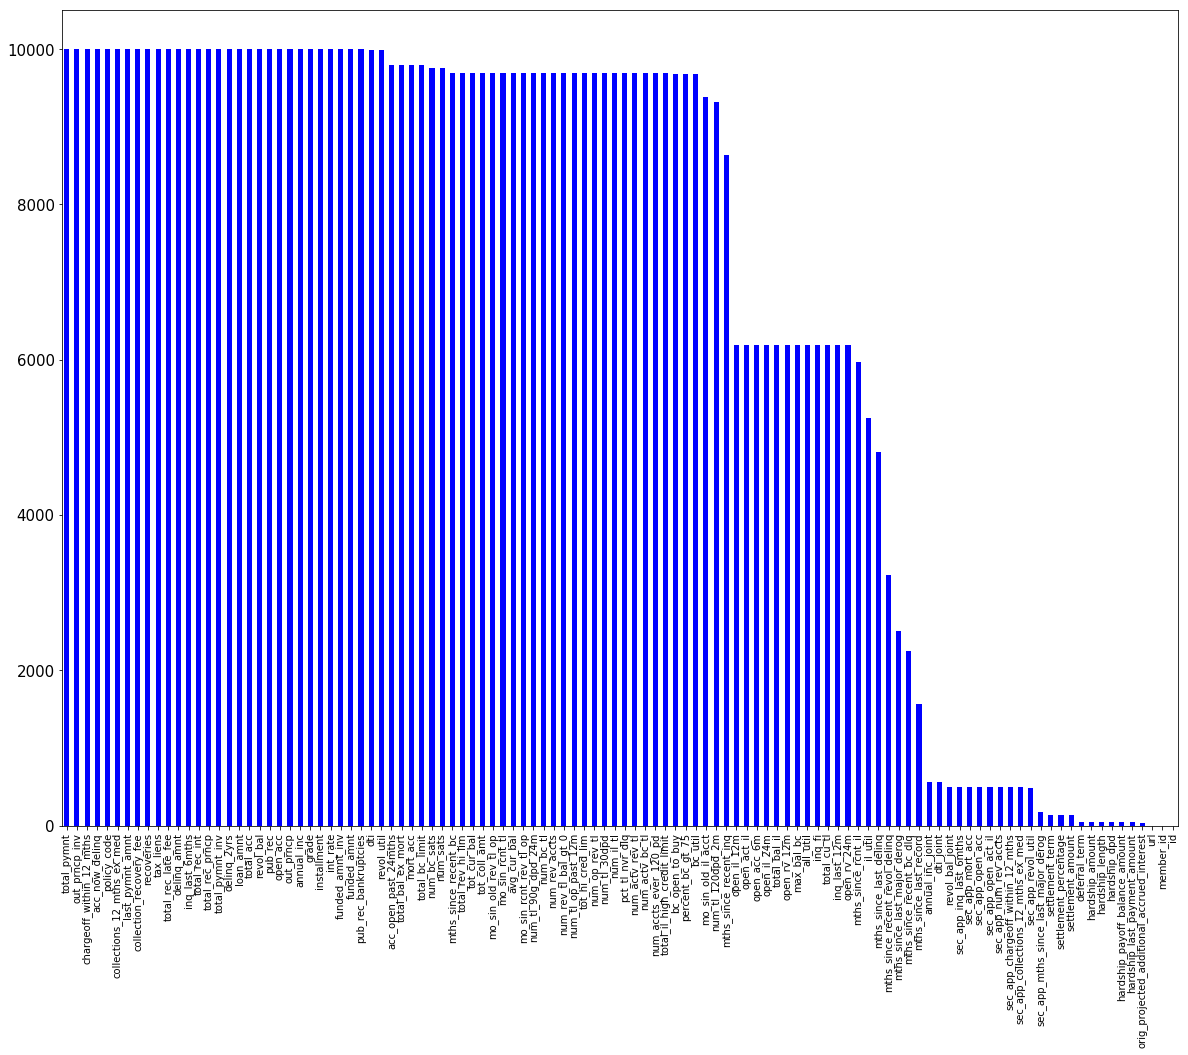

In [88]:
first_df = df.copy().sample(10000)

plt.figure(figsize=(20,15))
first_df.describe().loc['count'].sort_values(ascending = False).plot(kind = 'bar', color = 'b').tick_params(axis="y", labelsize=15);

### Categorical Values on first_df

In [92]:
# Get list of categorical features
df_first_cat_var = [col for col in first_df.columns if first_df[col].dtype.name == 'object']
first_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1035955,NaN,NaN,16000,16000,16000.0,36 months,9.99,516.20,5,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1485792,NaN,NaN,24000,24000,24000.0,60 months,18.06,610.23,3,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
708960,NaN,NaN,7200,7200,7200.0,36 months,14.46,247.70,4,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1029385,NaN,NaN,25250,25250,25225.0,36 months,16.55,894.59,3,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1498828,NaN,NaN,30000,30000,30000.0,36 months,16.02,1055.01,4,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


I first looked at how many unique values each categorical variable contained:

In [89]:
# Print out number of unique values from each feature
for col in list(first_df[df_first_cat_var].columns):
    print(col,':', first_df[col].nunique())

term : 2
sub_grade : 35
emp_title : 5738
emp_length : 11
home_ownership : 5
verification_status : 3
issue_d : 119
loan_status : 8
pymnt_plan : 2
desc : 551
purpose : 14
title : 597
zip_code : 801
addr_state : 50
earliest_cr_line : 527
initial_list_status : 2
last_pymnt_d : 103
next_pymnt_d : 7
last_credit_pull_d : 85
application_type : 2
verification_status_joint : 3
sec_app_earliest_cr_line : 248
hardship_flag : 2
hardship_type : 1
hardship_reason : 8
hardship_status : 3
hardship_start_date : 18
hardship_end_date : 18
payment_plan_start_date : 18
hardship_loan_status : 4
disbursement_method : 2
debt_settlement_flag : 2
debt_settlement_flag_date : 31
settlement_status : 3
settlement_date : 38


From this, as well as reading the data dictionary, there appear to be columns that are either redundant or would implicitly correlate with each other. Examples included but not limited to:

   - Hardship statuses and information 
   - Debt settlement statuses and information
   - 'purpose' and 'title' columns
   - 'grade' and 'subgrade' columns 
   - 'zip_code' and 'state'
   - Dates 

Note: Lots of the feature give the same information, they can be removed.

Things to do with the categorical variables

   - Turn the **grade** column into an ordinal variable X
   - Del the **sub_grade** to reduce redundancy
   - Del the **emp_title** to avoid creating too many more variables from dummies
   - Turn **emp_length** into ordinal variable, with '< 1 year' == 0.5 and '10+ years' == 20
   - Del the **desc** column, as NLP will not be used here
   - Del the **title** and **zip_code** column, as the **purpose** and **addr_state** provide this info with fewer possible values
   - Fill the missing values with 'Not Applicable'
   - Create dummy variables for the rest of the columns

Moving forward, I excluded such redundant columns as well the dates 

In [95]:
# Drop relevant columns
columns_to_exclude = ['id', 'member_id', 'issue_d', 'url', 'desc', 'title', 'zip_code', 'earliest_cr_line', 'last_pymnt_d',
                      'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_start_date', 'hardship_end_date',
                      'payment_plan_start_date', 'debt_settlement_flag_date', 'settlement_date', 'emp_title',
                     'sec_app_earliest_cr_line','sub_grade']

first_df.drop(columns_to_exclude, axis=1, inplace=True)
first_df.shape

(10000, 125)

In [97]:
df_first_cat_var = [col for col in first_df.columns if first_df[col].dtype.name == 'object']
for col in list(first_df[df_first_cat_var].columns):
    print(col,':', first_df[col].nunique())

term : 2
emp_length : 11
home_ownership : 5
verification_status : 3
loan_status : 8
pymnt_plan : 2
purpose : 14
addr_state : 50
initial_list_status : 2
application_type : 2
verification_status_joint : 3
hardship_flag : 2
hardship_type : 1
hardship_reason : 8
hardship_status : 3
hardship_loan_status : 4
disbursement_method : 2
debt_settlement_flag : 2
settlement_status : 3


Using get_dummies here would produce a much more acceptable addition of columns. 

Some of the categorical variables are ordinal and can be replaced with integers, including the **term** and **emp_length** features.

In [98]:
# Wierd space bug 
first_df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [99]:
# term
num_term = {' 36 months': 36, ' 60 months': 60}
first_df['term'] = first_df['term'].replace(num_term)

In [100]:
# emp_length
num_emp_length = {'< 1 year': 0.5,'1 year': 1,'2 years': 2, '3 years': 3,
                 '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                 '8 years': 8, '9 years': 9, '10+ years': 20}
first_df['emp_length'] = first_df['emp_length'].replace(num_emp_length)

In [104]:
# fill remainder cat. columns with "NA"
first_df[df_first_cat_var] = first_df[df_first_cat_var].fillna('Not Applicable', axis = 1)

This fully fills in all missing values for categorical variables!

In [105]:
# Another glimpse
first_df[df_first_cat_var].head()

,term,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type,verification_status_joint,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_loan_status,disbursement_method,debt_settlement_flag,settlement_status
1035955,36,0.5,RENT,Not Verified,Fully Paid,n,debt_consolidation,TX,f,Individual,Not Applicable,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
1485792,60,2,MORTGAGE,Source Verified,Current,n,credit_card,IN,w,Individual,Not Applicable,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
708960,36,2,RENT,Not Verified,Current,n,debt_consolidation,SC,w,Individual,Not Applicable,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
1029385,36,10,MORTGAGE,Not Verified,Fully Paid,n,debt_consolidation,CT,f,Individual,Not Applicable,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
1498828,36,10,OWN,Source Verified,Late (31-120 days),n,other,KS,w,Individual,Not Applicable,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable


### Numerical Values on first_df

In [115]:
df_first_num_var = [col for col in first_df.columns if first_df[col].dtype.name == 'int64' or first_df[col].dtype.name == 'float64']
first_df[df_first_num_var].head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,annual_inc,dti,delinq_2yrs,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
1035955,16000,16000,16000.0,36,9.99,516.20,5,75000.0,13.71,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1485792,24000,24000,24000.0,60,18.06,610.23,3,86000.0,20.83,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708960,7200,7200,7200.0,36,14.46,247.70,4,35000.0,24.83,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1029385,25250,25250,25225.0,36,16.55,894.59,3,57434.0,17.51,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498828,30000,30000,30000.0,36,16.02,1055.01,4,100000.0,17.18,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


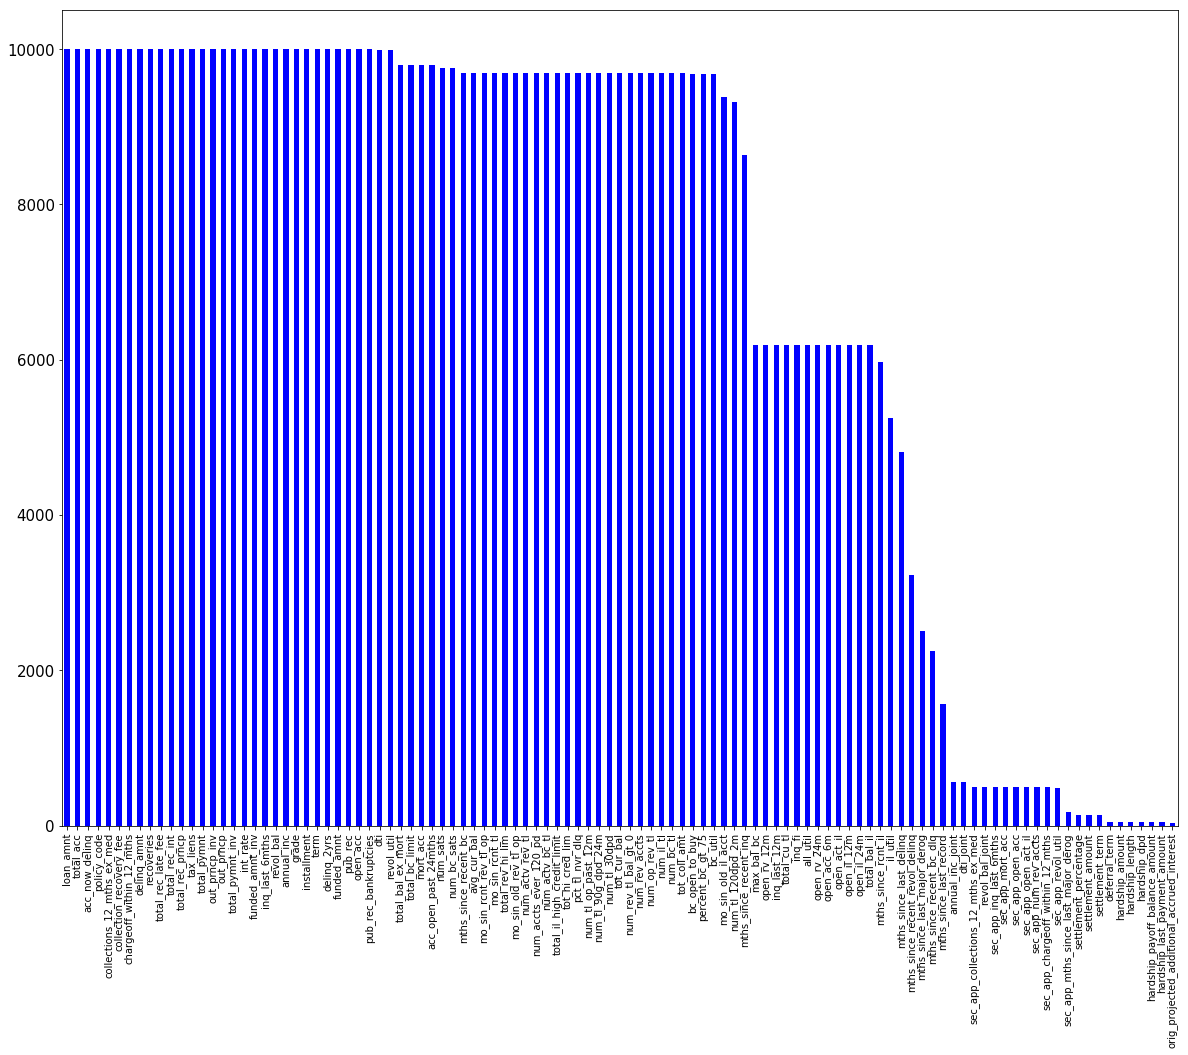

In [121]:
plt.figure(figsize=(20,15))
first_df.describe().loc['count'].sort_values(ascending = False).plot(kind = 'bar', color = 'b').tick_params(axis="y", labelsize=15);



From the graph above thus far, for the purposes of this project, I removed any remainder columns that had at least 35% missing values. This is a sweet spot to eliminate the least amount of columns as well as rows. 

In [122]:
# Total row size is 10,000
nans = first_df.isnull().sum().to_frame(name='Nans')
high_nans = nans[nans['Nans'] > 3500]
high_nans

,Nans
mths_since_last_delinq,5190
mths_since_last_record,8440
mths_since_last_major_derog,7489
annual_inc_joint,9433
dti_joint,9433
open_acc_6m,3811
open_act_il,3811
open_il_12m,3811
open_il_24m,3811
mths_since_rcnt_il,4026


The columns with the most missing values appear to be those relating to joint accounts, secondary and open accounts, hardhip loans, and debt settlement information.

In [123]:
first_df = first_df.drop(high_nans.index, axis = 1)
first_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_loan_status,disbursement_method,debt_settlement_flag,settlement_status
1035955,16000,16000,16000.0,36,9.99,516.20,5,0.5,RENT,75000.0,...,39500.0,39400.0,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
1485792,24000,24000,24000.0,60,18.06,610.23,3,2,MORTGAGE,86000.0,...,8900.0,97094.0,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
708960,7200,7200,7200.0,36,14.46,247.70,4,2,RENT,35000.0,...,6550.0,71488.0,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
1029385,25250,25250,25225.0,36,16.55,894.59,3,10,MORTGAGE,57434.0,...,43700.0,0.0,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable
1498828,30000,30000,30000.0,36,16.02,1055.01,4,10,OWN,100000.0,...,32100.0,45293.0,N,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Cash,N,Not Applicable


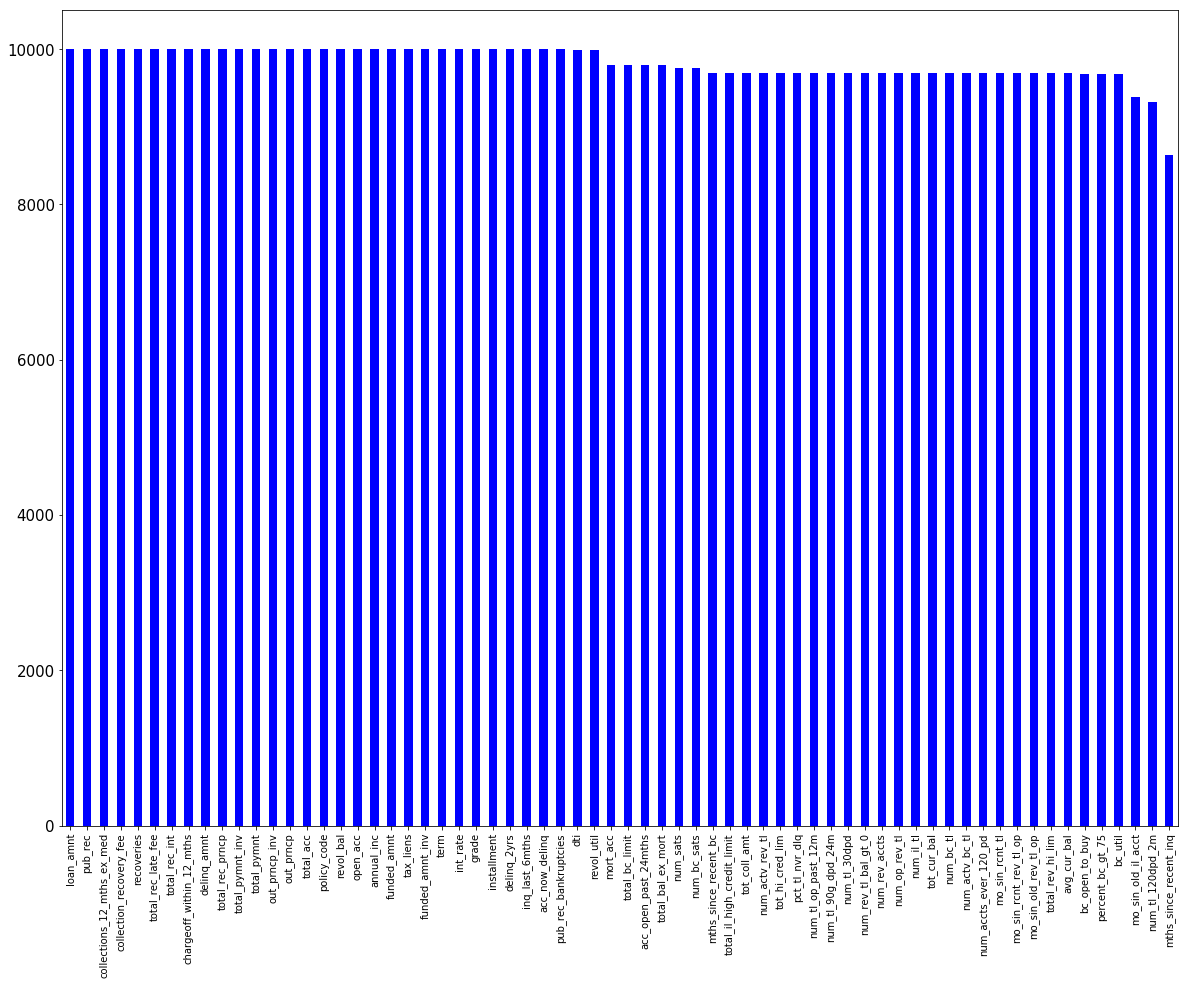

In [124]:
plt.figure(figsize=(20,15))
first_df.describe().loc['count'].sort_values(ascending = False).plot(kind = 'bar', color = 'b').tick_params(axis="y", labelsize=15);


The graph shows at this point that there are no longer any columns with a drastic number of missing values. 

In [130]:
second_df = df.copy()

In [133]:
second_df = second_df[first_df.columns]
second_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,total_bc_limit,total_il_high_credit_limit,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_loan_status,disbursement_method,debt_settlement_flag,settlement_status
0,2500,2500,2500.0,36 months,13.56,84.92,4,10+ years,RENT,55000.0,...,36500.0,18124.0,N,NaN,NaN,NaN,NaN,Cash,N,NaN
1,30000,30000,30000.0,60 months,18.94,777.23,3,10+ years,MORTGAGE,90000.0,...,15000.0,94072.0,N,NaN,NaN,NaN,NaN,Cash,N,NaN
2,5000,5000,5000.0,36 months,17.97,180.69,3,6 years,MORTGAGE,59280.0,...,13800.0,10000.0,N,NaN,NaN,NaN,NaN,Cash,N,NaN
3,4000,4000,4000.0,36 months,18.94,146.51,3,10+ years,MORTGAGE,92000.0,...,5000.0,44984.0,N,NaN,NaN,NaN,NaN,Cash,N,NaN
4,30000,30000,30000.0,60 months,16.14,731.78,4,10+ years,MORTGAGE,57250.0,...,9300.0,32332.0,N,NaN,NaN,NaN,NaN,Cash,N,NaN


In [135]:
# term
num_term = {' 36 months': 36, ' 60 months': 60}
second_df['term'] = second_df['term'].replace(num_term)

In [136]:
# emp_length
num_emp_length = {'< 1 year': 0.5,'1 year': 1,'2 years': 2, '3 years': 3,
                 '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                 '8 years': 8, '9 years': 9, '10+ years': 20}
second_df['emp_length'] = second_df['emp_length'].replace(num_emp_length)

In [137]:
# fill remainder cat. columns with "NA"
df_second_cat_var = [col for col in second_df.columns if second_df[col].dtype.name == 'object']

second_df[df_second_cat_var] = second_df[df_second_cat_var].fillna('Not Applicable', axis = 1)

In [145]:
second_df = pd.get_dummies(second_df, dummy_na=True)

In [146]:
print(second_df.shape)
print(second_df.dropna(how='any').shape)

(2260668, 209)
(1684854, 209)


## Machine Learning Time!!

The dataset I used **df_dropna_any** had all rows with any missing values removed

In [ ]:
df_dropna_any = second_df.dropna(how='any')

In [152]:
# I decided to actually stick with using a smaller subset of the dataset

df_dropna_any_sample = df_dropna_any.copy().sample(50000)

In [153]:
df_dropna_any_sample.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,dti,...,disbursement_method_DirectPay,disbursement_method_nan,debt_settlement_flag_N,debt_settlement_flag_Y,debt_settlement_flag_nan,settlement_status_ACTIVE,settlement_status_BROKEN,settlement_status_COMPLETE,settlement_status_Not Applicable,settlement_status_nan
1284452,14000,14000,14000.0,60,16.55,344.56,3,5.0,50000.0,13.25,...,0,0,1,0,0,0,0,0,1,0
2259723,20125,20125,20125.0,36,9.44,644.10,5,20.0,57000.0,14.78,...,0,0,1,0,0,0,0,0,1,0
1373840,3000,3000,3000.0,36,11.49,98.92,5,6.0,25000.0,15.46,...,0,0,1,0,0,0,0,0,1,0
989343,11200,11200,11200.0,36,12.05,372.27,4,8.0,70000.0,28.90,...,0,0,1,0,0,0,0,0,1,0
358502,12000,12000,12000.0,36,9.92,386.76,5,4.0,50000.0,11.35,...,0,0,1,0,0,0,0,0,1,0


In [167]:
X = df_dropna_any.drop('grade', axis = 1)
y = df_dropna_any['grade']

In [155]:
def train_and_test_model(X, y, model, param_grid):
    '''Takes in a dataframe and prarmeter grid, splits the data, 
    and optimizes the hyperparameters for the best score through
    a grid search.
    '''
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    
    # Instantiate the GridSearchCV object: model_cv
    model_cv = GridSearchCV(model, param_grid=param_grid, cv=5)
    
    # Fit the model to the training data
    model_cv.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = model_cv.predict(X_test)
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

In [160]:
# Instantiate the Model 

logreg = LogisticRegression(C=1, solver='liblinear')
print(cross_val_score(logreg, X, y, cv=5))

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/s

[0.51959608 0.51434857 0.4632     0.5041     0.47124137]


/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The mean of the list produced above shows the model had 50% accuracy, not the best.

In [164]:
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores.mean())

0.3305214275083789


In [166]:
tree = DecisionTreeClassifier()
scores = cross_val_score(tree, X, y, cv=10, scoring='accuracy')
print(scores.mean())

0.9417601009297961


In [170]:
RF = RandomForestClassifier()
scores = cross_val_score(RF, X, y, cv=5, scoring='accuracy')
print(scores.mean())

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lucas

0.8060620815020133


From the cross_val_score results, we can see that the DesicionTreeClassifier obtained the highest accuracy score of 94.17%. The Random Forest Model outputed a score of 80.6%. We have to be mindful that this could be an issue of over fitting.  

## Future work

- **Use the whole data set**: In order to save valuable time, I used a sample of the dataset. With more resources, I would fit the model to the entire dataset
- **Perform a grid search on more model types**: I would use Sklearn's GridSearchCV function perform hyperparameter tuning on the different supervised models
- **Fill in missing numerical values**: I would further examine the missing numerical values by feature to see if there's an intuitive number they can be filled with (See the Supplement section below). Regression Analysis and creating sub-models to predict missing values on columns are also possible and stronger options.
- **Scale the dataset**: Could improve performance for some models such as KNearestNeighbors.
- **Look deeper into the dates**: The dates could be feature engineered to show lengths of certain important time periods, which could impact credit grade
- **Look deeper into the miscellaneous cases**: The joint accounts, secondary and open accounts, debt settlement  information, and hardhip loans may have some important impact on grade (See the Supplement section below for a brief analysis on Hardship Columns)



# Supplement Section

## Filling numerical columns

We can look at the data distribution of certain features, like **inq_last_6mths**, **delinq_2yrs**.

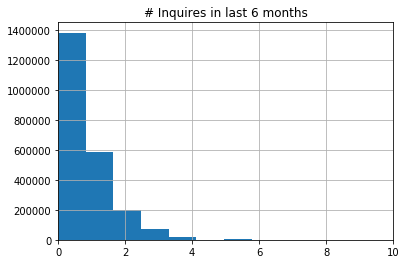

In [175]:
df['inq_last_6mths'].hist(bins=40)
plt.xlim(0, 10);
plt.title('# Inquires in last 6 months');

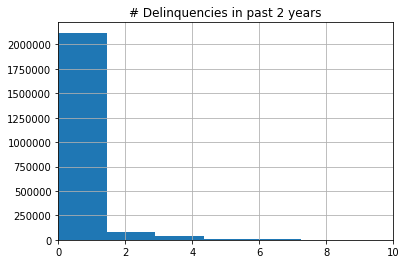

In [176]:
df['delinq_2yrs'].hist(bins=40)
plt.xlim(0, 10);
plt.title('# Delinquencies in past 2 years');

Given the massive mode on these columns, Filling their missing values with 0 could be acceptable. This is just an example that can be applied widely. 

## EDA on Hardship Columns 

According to the data dictionary, the feature **hardship_flag** indicates whether a consumer is or is not on a hardship plan. Thus, I extract a subset of the dataframe that includes all features related to hardship plans. I keep in the **grade** column since that is the feature we are trying to predict. I name this dataframe: **df_hardships**

In [177]:
hardship = [col for col in list(df.columns) if 'hardship' in col]
hardship

['hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount']

In [178]:
df_hardships = df[['grade'] + hardship][df['hardship_flag']=='Y']
print(df_hardships.shape)
df_hardships.head()

(885, 13)


,grade,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_amount,hardship_start_date,hardship_end_date,hardship_length,hardship_dpd,hardship_loan_status,hardship_payoff_balance_amount,hardship_last_payment_amount
95385,1,Y,INTEREST ONLY-3 MONTHS DEFERRAL,UNEMPLOYMENT,ACTIVE,378.39,Feb-2019,Apr-2019,3.0,22.0,Late (16-30 days),15351.85,1045.41
272397,3,Y,INTEREST ONLY-3 MONTHS DEFERRAL,EXCESSIVE_OBLIGATIONS,ACTIVE,5.95,Dec-2018,Feb-2019,3.0,28.0,Late (16-30 days),424.11,165.99
345793,6,Y,INTEREST ONLY-3 MONTHS DEFERRAL,UNEMPLOYMENT,ACTIVE,116.91,Feb-2019,Apr-2019,3.0,7.0,In Grace Period,19256.58,138.61
346780,3,Y,INTEREST ONLY-3 MONTHS DEFERRAL,UNEMPLOYMENT,ACTIVE,121.43,Feb-2019,Apr-2019,3.0,16.0,Late (16-30 days),8100.99,186.19
348105,4,Y,INTEREST ONLY-3 MONTHS DEFERRAL,UNEMPLOYMENT,ACTIVE,183.65,Feb-2019,Apr-2019,3.0,23.0,Late (16-30 days),16586.35,252.07


In [179]:
# df_hardships only has ACTIVE statuses, otherwise, they are COMPLETED, BROKEN or missing.

print(df_hardships['hardship_status'].unique())
print(df['hardship_status'][df['hardship_flag']=='N'].unique())

['ACTIVE']
[nan 'COMPLETED' 'BROKEN']


In [180]:
# The hardship plans only come in one form: INTEREST ONLY-3 MONTHS DEFERRAL. Could be removed

print(df['hardship_type'].unique())
print(df_hardships['hardship_type'].unique())

[nan 'INTEREST ONLY-3 MONTHS DEFERRAL']
['INTEREST ONLY-3 MONTHS DEFERRAL']


In [181]:
# Confirms the lengths of the 3-month plan...

print(df['hardship_length'].unique())
print(df_hardships['hardship_length'].unique())

[nan  3.]
[3.]


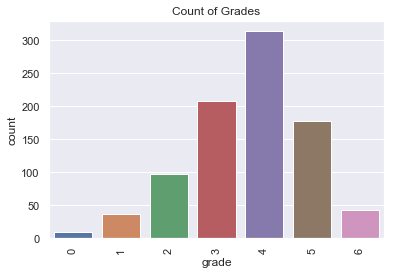

In [183]:
# Count of grades, statuses, and reasons of those with hardship plans
# Reminder: num_grades = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0} In [5]
sns.set(style="darkgrid")
_ = sns.countplot(x='grade', data=df_hardships)
plt.title('Count of Grades');
plt.xticks(rotation=90);

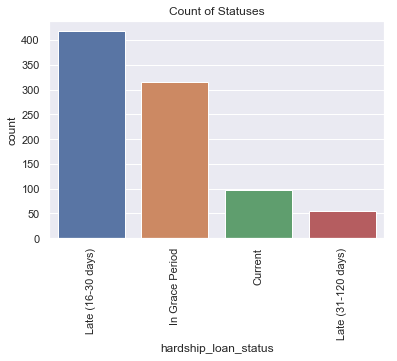

In [184]:
sns.set(style="darkgrid")
_ = sns.countplot(x='hardship_loan_status', data=df_hardships)
plt.title('Count of Statuses');
plt.xticks(rotation=90);

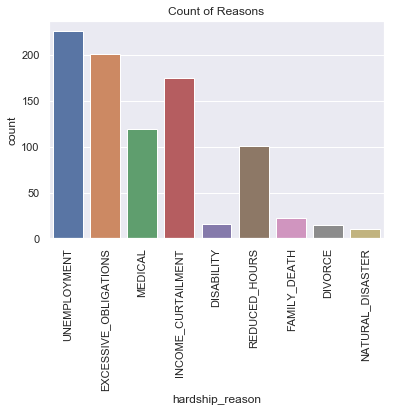

In [185]:
sns.set(style="darkgrid")
_ = sns.countplot(x='hardship_reason', data=df_hardships)
plt.title('Count of Reasons');
plt.xticks(rotation=90);

- Observations from EDA on hardships:
    - The data distribution of those under a hardship loan plan fell under a mean between Grade C and Grade D
    - Hardship plans only come in a INTEREST ONLY-3 MONTHS DEFERRAL plan
    - The most common reasons for offering the hardship plan were UNEMPLOYMENT, EXCESSIVE_OBLIGATIONS, INCOME_CURTAILMENT, and MEDICAL reasons
    - The most frequent hardship loan statuses were in grace, period, or moderately late

